In [128]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
df = pd.read_csv('train.csv')

# Check and Remove Outliers

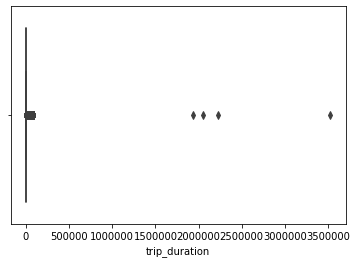

In [186]:
sns.boxplot(df.trip_duration)

In [190]:
trip_duration_describe = df.trip_duration.describe()

## Using 1.5 IQR rule
IQR = trip_duration_describe['75%'] - trip_duration_describe['25%'] 

df_cleaned = \
df.copy()\
.loc[lambda x: x.trip_duration < trip_duration_describe['75%'] + 1.5 * IQR]\
.loc[lambda x: x.trip_duration > trip_duration_describe['25%'] - 1.5 * IQR]

## Can also use leverage values or distance values for regression

In [204]:
print("{} Outliers removed".format(df.shape[0] - df_cleaned.shape[0]))

97331 Outliers removed


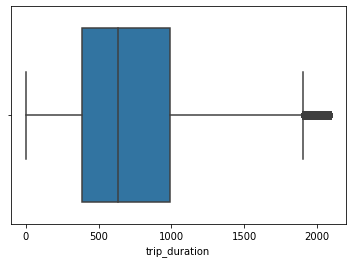

In [189]:
sns.boxplot(df.trip_duration)

# Visualize pickup and drop off

In [205]:
longitude = \
df.melt(id_vars = 'id',
        value_vars = ['pickup_longitude', 'dropoff_longitude'],
        value_name = 'longitude',
        var_name = ['location_type'])

latitude = \
df.melt(id_vars = 'id',
        value_vars = ['pickup_latitude', 'dropoff_latitude'],
        value_name = 'latitude',
        var_name = ['location_type'])

longitude.location_type = longitude.location_type.apply(lambda x: x[:x.find('_')]) 
latitude.location_type = latitude.location_type.apply(lambda x: x[:x.find('_')]) 

df_locations_1 = \
longitude\
.merge(latitude, on = ['id', 'location_type'], how = 'inner')

In [206]:
df_locations_1.head(3)

,id,location_type,longitude,latitude
0,id2875421,pickup,-73.982155,40.767937
1,id2377394,pickup,-73.980415,40.738564
2,id3858529,pickup,-73.979027,40.763939


In [215]:
df_locations_2 = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

In [217]:
df_locations_2.head(3)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,-73.982155,40.767937,-73.964630,40.765602
1,-73.980415,40.738564,-73.999481,40.731152
2,-73.979027,40.763939,-74.005333,40.710087


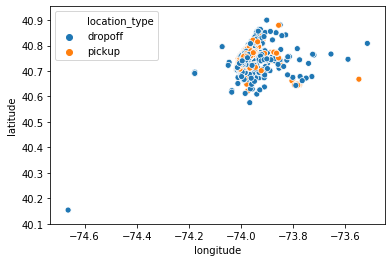

In [208]:
sns.scatterplot(data = df_locations.sample(n = 5000), x = 'longitude', y = 'latitude', hue = 'location_type')
plt.show()

## Initialize Map

# Find Distance

# Google Maps API

# Build Regression Model